# Assignment 2 : Unet with Attention Block

## Importing Necessary Libraries

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.layers import Layer, Input
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model, Sequential
from keras.layers import Concatenate, UpSampling2D
import cv2
from keras.layers import Conv2D, Dense, MaxPooling2D, BatchNormalization, Flatten, Dropout, Conv2DTranspose
import os
import random
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation,Add,Multiply


## Data Loading

In [2]:
path = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset"
listDir = []
for dir in os.listdir(path):
    if dir != "classes.json":
        listDir.append(dir)

listDir = sorted(listDir)

In [3]:
def loadImg(path, dirTile):
    input_img, mask_img = [], []
    path = os.path.join(path, dirTile)
    inpDir, maskDir = os.listdir(path)
    
    imgDirs = sorted(os.listdir(os.path.join(path, inpDir)))
    mask_imgDirs = sorted(os.listdir(os.path.join(path, maskDir)))
    
    for imgDir in imgDirs:
        imgDir = os.path.join(path, inpDir, imgDir)
        img = load_img(imgDir, target_size = (224, 224))
        img = tf.convert_to_tensor(img, dtype = tf.float32) / 255.0
        input_img.append(img)
    
    for mask_imgDir in mask_imgDirs:
        mask_imgDir = os.path.join(path, maskDir, mask_imgDir)
        mask = load_img(mask_imgDir, target_size = (224, 224))
        mask = tf.convert_to_tensor(mask, dtype = tf.float32) / 255.0
        mask_img.append(mask)
    
    return input_img, mask_img

In [4]:
def loadData(path = path, listDir = listDir):
    imgs_data, masks_data = [], []
    for dirTile in listDir:
        input_imgs, mask_imgs = loadImg(path, dirTile)
        
        imgs_data.extend(input_imgs)
        masks_data.extend(mask_imgs)
    return imgs_data, masks_data

In [5]:
input_imgs, mask_imgs = loadData()

## Showing a sample

(-0.5, 223.5, 223.5, -0.5)

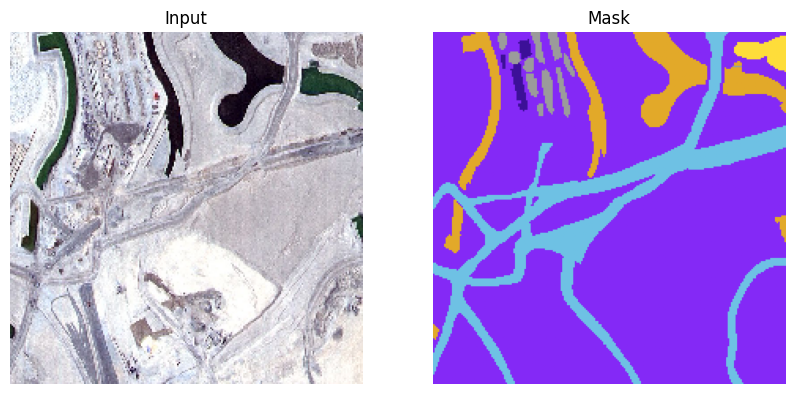

In [6]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(input_imgs[0])
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask_imgs[0])
plt.axis("off")

In [7]:
xTrain, xVal, yTrain, yVal = train_test_split(input_imgs, mask_imgs, test_size=0.2, random_state=42)

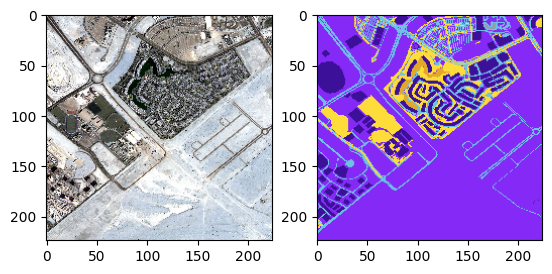

In [8]:
plt.subplot(1, 2, 1)
plt.imshow(xTrain[1])

plt.subplot(1, 2, 2)
plt.imshow(yTrain[1])

In [9]:
xTrain = np.array(xTrain)
yTrain = np.array(yTrain)
xVal = np.array(xVal)
yVal = np.array(yVal)

(-0.5, 223.5, 223.5, -0.5)

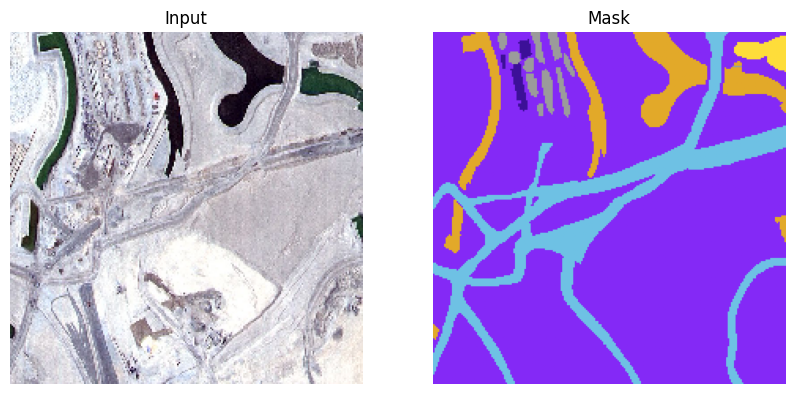

In [10]:
plt.figure(figsize = (10, 6))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(input_imgs[0])
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask_imgs[0])
plt.axis("off")

In [11]:
xTrain,xVal,yTrain,yVal = train_test_split(input_imgs,mask_imgs,test_size=0.2,random_state=42)

In [12]:
trainData = np.array(list(zip(xTrain,yTrain)))
testData = np.array(list(zip(xVal,yVal)))

## Conv Block

In [13]:
def convBlock(x, filters):
    x = Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    return x

## Attention Block with gates

In [14]:
def attentionBlock(skipCon, gatSignal, filters):
    txVal = Conv2D(filters, (1, 1), padding="same")(skipCon)  
    phiVal = Conv2D(filters, (1, 1), padding="same")(gatSignal)  
    add = Add()([txVal, phiVal])  
    act = Activation("relu")(add)
    psi = Conv2D(filters, (1, 1), padding="same", activation="sigmoid")(act)  
    out = Multiply()([skipCon, psi])  
    return out

## Model Building

In [15]:
inputs = Input(shape=(224, 224, 3))

# Encoder
c1 = convBlock(inputs, 64)
p1 = MaxPooling2D((2, 2))(c1)
c2 = convBlock(p1, 128)
p2 = MaxPooling2D((2, 2))(c2)
c3 = convBlock(p2, 256)
p3 = MaxPooling2D((2, 2))(c3)
c4 = convBlock(p3, 512)
p4 = MaxPooling2D((2, 2))(c4)

# Bottleneck
c5 = convBlock(p4, 1024)

# Decoder
u6 = UpSampling2D((2, 2))(c5)
att6 = attentionBlock(c4, u6, 512) 
concat6 = Concatenate()([u6, att6])
c6 = convBlock(concat6, 512)

u7 = UpSampling2D((2, 2))(c6)
att7 = attentionBlock(c3, u7, 256)
concat7 = Concatenate()([u7, att7])
c7 = convBlock(concat7, 256)

u8 = UpSampling2D((2, 2))(c7)
att8 = attentionBlock(c2, u8, 128)
concat8 = Concatenate()([u8, att8])
c8 = convBlock(concat8, 128)

u9 = UpSampling2D((2, 2))(c8)
att9 = attentionBlock(c1, u9, 64)
concat9 = Concatenate()([u9, att9])
c9 = convBlock(concat9, 64)

outs = Conv2D(3,(1,1), activation="sigmoid")(c9)

In [16]:
model = Model(inputs,outs)

## Unet with Attention model summary

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 64)   │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 112, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 128)  │        147,584 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 256)    │        590,080 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 28, 28, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 28, 28, 512)    │          2,048 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 28, 28, 512)    │      2,359,808 │ batch_normalization_3… │
├──────────────────────

 Total params: 32,786,371 (125.07 MB)

 Trainable params: 32,780,483 (125.05 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [18]:
model.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])

## Training the model

In [19]:
history = model.fit(np.array(xTrain),np.array(yTrain),
                    batch_size = 8, 
                    epochs = 10, 
                    validation_data = (np.array(xVal), np.array(yVal)))

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.5440 - loss: 0.6850 - val_accuracy: 0.2373 - val_loss: 118.4131
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.8455 - loss: 0.5670 - val_accuracy: 0.0020 - val_loss: 533.4372
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.8956 - loss: 0.5419 - val_accuracy: 0.1075 - val_loss: 83.8345
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.8851 - loss: 0.5524 - val_accuracy: 0.4589 - val_loss: 15.5124
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.8609 - loss: 0.5581 - val_accuracy: 0.7083 - val_loss: 4.7670
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.8740 - loss: 0.5546 - val_accuracy: 0.7099 - val_loss: 2.4579
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.9045 - loss: 0.5431 - val_accuracy: 0.7434 - val_loss: 1.6835
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.8974 - loss: 0.5448 - val_accuracy: 0.7053 - val_l

## Accuracy and loss during training

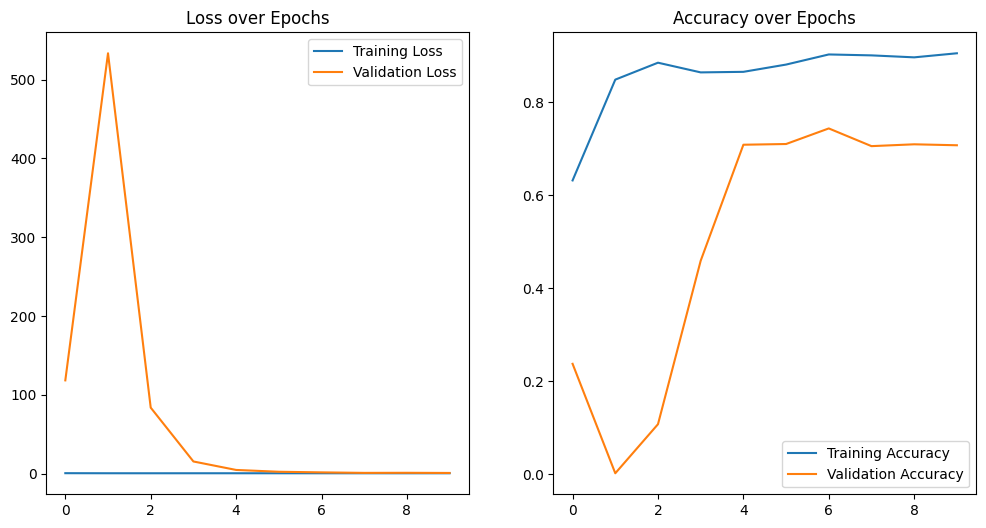

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

In [21]:
model.save("unetAttentionModel.h5")

## Evaluating the model

In [24]:
loss, accuracy = model.evaluate(np.array(xVal),np.array(yVal))
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.7072 - loss: 0.9457
Validation Loss: 0.9457, Validation Accuracy: 0.7072


In [27]:
testp = np.random.randint(len(xVal))
testImg = np.expand_dims(xVal[testp], axis=0)
predMask = model.predict(testImg)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


## Showing original image,ground truth and predicted mask

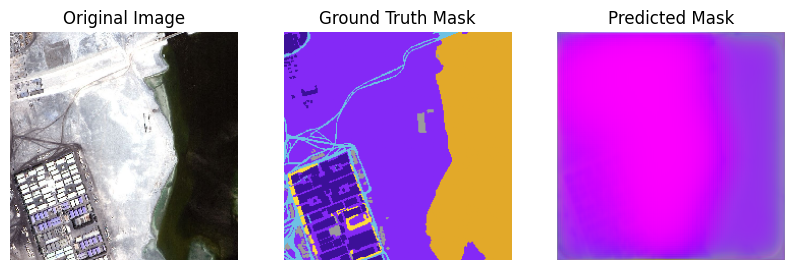

In [30]:
plt.figure(figsize=(10,3))

plt.subplot(1,3,1)
plt.imshow(xVal[testp])
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(yVal[testp].numpy().squeeze(), cmap="gray") 
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(predMask.squeeze(), cmap="gray") 
plt.title("Predicted Mask")
plt.axis("off")

plt.show()
